In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from typing import Optional, Tuple, List, Dict, Union


class AcademicPCA:
    """
    A comprehensive PCA class for exploratory data analysis in clinical research.

    Features
    --------
    - Automatic PC selection based on cumulative explained variance threshold
    - Biplot with feature vectors and sample scores
    - Scree plot and variance table
    - Loadings and correlation analysis
    - Robust to outliers using RobustScaler
    - Fully documented and publication-ready

    Parameters
    ----------
    min_explained_variance : float, default 0.70
        Minimum cumulative explained variance ratio to retain components.
        Must be in [0.5, 1.0]. Example: 0.70 → keep PCs until 70% variance explained.
    scaler : {'robust', 'standard'}, default 'robust'
        Scaling method. 'robust' is recommended for clinical data with outliers.
    n_components : int or None, default None
        Number of components to compute. If None, all are computed.
    random_state : int, default 42
        Random seed for reproducibility.
    """

    def __init__(
        self,
        min_explained_variance: float = 0.70,
        scaler: str = 'robust',
        n_components: Optional[int] = None,
        random_state: int = 42
    ):
        if not 0.5 <= min_explained_variance <= 1.0:
            raise ValueError("min_explained_variance must be in [0.5, 1.0]")
        if scaler not in ['robust', 'standard']:
            raise ValueError("scaler must be 'robust' or 'standard'")

        self.min_explained_variance = min_explained_variance
        self.scaler_type = scaler
        self.n_components = n_components
        self.random_state = random_state

        self.scaler = None
        self.pca = None
        self.X_scaled = None
        self.X_pca = None
        self.feature_names = None
        self.selected_pcs = 0
        self.is_fitted = False

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Optional[Union[pd.Series, np.ndarray]] = None
    ) -> 'AcademicPCA':
        """
        Fit the PCA model with automatic component selection.

        Parameters
        ----------
        X : DataFrame or ndarray
            Input features (numeric only).
        y : Series or ndarray, optional
            Target variable for coloring in biplot.

        Returns
        -------
        self
        """
        # Convert to DataFrame if needed
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.select_dtypes(include=[np.number]).columns.tolist()
            X_num = X[self.feature_names].copy()
        else:
            X_num = pd.DataFrame(X)
            self.feature_names = [f'Feature_{i}' for i in range(X_num.shape[1])]

        X_array = X_num.values

        # Scale data
        self.scaler = RobustScaler() if self.scaler_type == 'robust' else StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X_array)

        # PCA
        pca_full = PCA(n_components=self.n_components, random_state=self.random_state)
        pca_full.fit(self.X_scaled)

        # Select components by variance threshold
        cum_var = np.cumsum(pca_full.explained_variance_ratio_)
        self.selected_pcs = np.searchsorted(cum_var, self.min_explained_variance) + 1
        self.selected_pcs = max(self.selected_pcs, 2)  # At least 2 for visualization

        # Final PCA
        self.pca = PCA(n_components=self.selected_pcs, random_state=self.random_state)
        self.X_pca = self.pca.fit_transform(self.X_scaled)

        self.is_fitted = True
        print(f"PCA fitted: {self.selected_pcs} components explain "
              f"{cum_var[self.selected_pcs-1]:.1%} of variance "
              f"(threshold: {self.min_explained_variance})")

        return self

    def transform(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Transform new data using fitted PCA."""
        if not self.is_fitted:
            raise RuntimeError("PCA must be fitted first using .fit()")
        X_num = X[self.feature_names] if isinstance(X, pd.DataFrame) else X
        X_scaled = self.scaler.transform(X_num)
        return self.pca.transform(X_scaled)

    def scree_plot(self, save_path: Optional[str] = None) -> None:
        """Plot scree plot with cumulative variance and threshold line."""
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")

        full_pca = PCA(n_components=None, random_state=self.random_state)
        full_pca.fit(self.X_scaled)
        var_ratio = full_pca.explained_variance_ratio_
        cum_var = np.cumsum(var_ratio)

        plt.figure()
        plt.plot(range(1, len(var_ratio)+1), var_ratio, 'o-', label='Individual', color='steelblue')
        plt.plot(range(1, len(cum_var)+1), cum_var, 's-', label='Cumulative', color='darkorange')
        plt.axhline(self.min_explained_variance, color='blue', linestyle='--',
                   label=f'Threshold ({self.min_explained_variance})')
        plt.axvline(self.selected_pcs, color='red', linestyle=':',
                   label=f'Selected ({self.selected_pcs} PCs)')

        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot with Variance Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def biplot(
        self,
        y: Optional[Union[pd.Series, np.ndarray]] = None,
        title: str = "PCA Biplot: Feature Vectors and Sample Distribution",
        save_path: Optional[str] = None
    ) -> None:
        """
        Create a biplot showing both scores (samples) and loadings (features).

        Parameters
        ----------
        y : array-like, optional
            Class labels for coloring samples.
        title : str
            Plot title.
        save_path : str, optional
            Path to save figure.
        """
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")

        pc1, pc2 = 0, 1
        xs = self.X_pca[:, pc1]
        ys = self.X_pca[:, pc2]

        # Scale loadings
        loadings = self.pca.components_.T * np.sqrt(self.pca.explained_variance_)
        scale_factor = max(xs.max(), ys.max()) * 0.8

        plt.figure()

        # Scatter plot of samples
        if y is not None:
            scatter = plt.scatter(xs, ys, c=y, cmap='RdYlBu', alpha=0.7, s=50)
            plt.colorbar(scatter, label='Class')
        else:
            plt.scatter(xs, ys, alpha=0.6, s=50)

        # Feature vectors
        for i, feature in enumerate(self.feature_names):
            plt.arrow(0, 0, loadings[i, pc1] * scale_factor, loadings[i, pc2] * scale_factor,
                     color='red', alpha=0.9, width=0.001, head_width=0.03, linewidth=1.5)
            plt.text(loadings[i, pc1] * scale_factor * 1.15,
                     loadings[i, pc2] * scale_factor * 1.15,
                     feature, color='darkred', ha='center', va='center', fontsize=11)

        plt.xlabel(f'PC1 ({self.pca.explained_variance_ratio_[pc1]:.1%} variance)')
        plt.ylabel(f'PC2 ({self.pca.explained_variance_ratio_[pc2]:.1%} variance)')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def get_loadings(self) -> pd.DataFrame:
        """Return loadings (contribution of original features to PCs)."""
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")
        loadings = self.pca.components_.T * np.sqrt(self.pca.explained_variance_)
        return pd.DataFrame(
            loadings,
            columns=[f'PC{i+1}' for i in range(self.selected_pcs)],
            index=self.feature_names
        ).round(4)

    def get_variance_table(self) -> pd.DataFrame:
        """Return explained variance table."""
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")
        var_ratio = self.pca.explained_variance_ratio_
        cum_var = np.cumsum(var_ratio)
        return pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(var_ratio))],
            'Explained Variance': var_ratio.round(4),
            'Cumulative Variance': cum_var.round(4)
        })

    def correlation_with_pc1(self, original_data: pd.DataFrame) -> pd.Series:
        """Compute Pearson correlation between original features and PC1."""
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")
        df_orig = original_data[self.feature_names]
        pc1_scores = pd.Series(self.X_pca[:, 0], name='PC1')
        return df_orig.corrwith(pc1_scores).sort_values(ascending=False).round(4)

    def summary(self) -> None:
        """Print comprehensive summary."""
        if not self.is_fitted:
            raise RuntimeError("Fit the model first.")
        print("\n" + "="*60)
        print(" ACADEMIC PCA SUMMARY")
        print("="*60)
        print(f"Scaler: {self.scaler_type.capitalize()}Scaler")
        print(f"Variance threshold: {self.min_explained_variance}")
        print(f"Selected components: {self.selected_pcs}")
        print(f"Cumulative variance: {np.cumsum(self.pca.explained_variance_ratio_)[-1]:.1%}")
        print("\nExplained Variance per PC:")
        print(self.get_variance_table())
        print("\nTop contributors to PC1:")
        print(self.correlation_with_pc1(pd.DataFrame(self.X_scaled, columns=self.feature_names)).head(6))
        print("="*60)

Output directory: Results
Data loaded successfully.
Indian: 30691 samples, 11 features
Cirrhosis (after drop ID/N_Days): 5271 samples, 17 features
Indian class: {0: 0.714, 1: 0.286}
Cirrhosis stage: {2.0: 0.403, 3.0: 0.34, 1.0: 0.212, 0.0: 0.046}

PCA Configuration:
   • Variance threshold: 0.75
   • Scaler: StandardScaler

1. INDIAN LIVER PATIENT DATASET
PCA fitted: 4 components explain 77.3% of variance (threshold: 0.75)


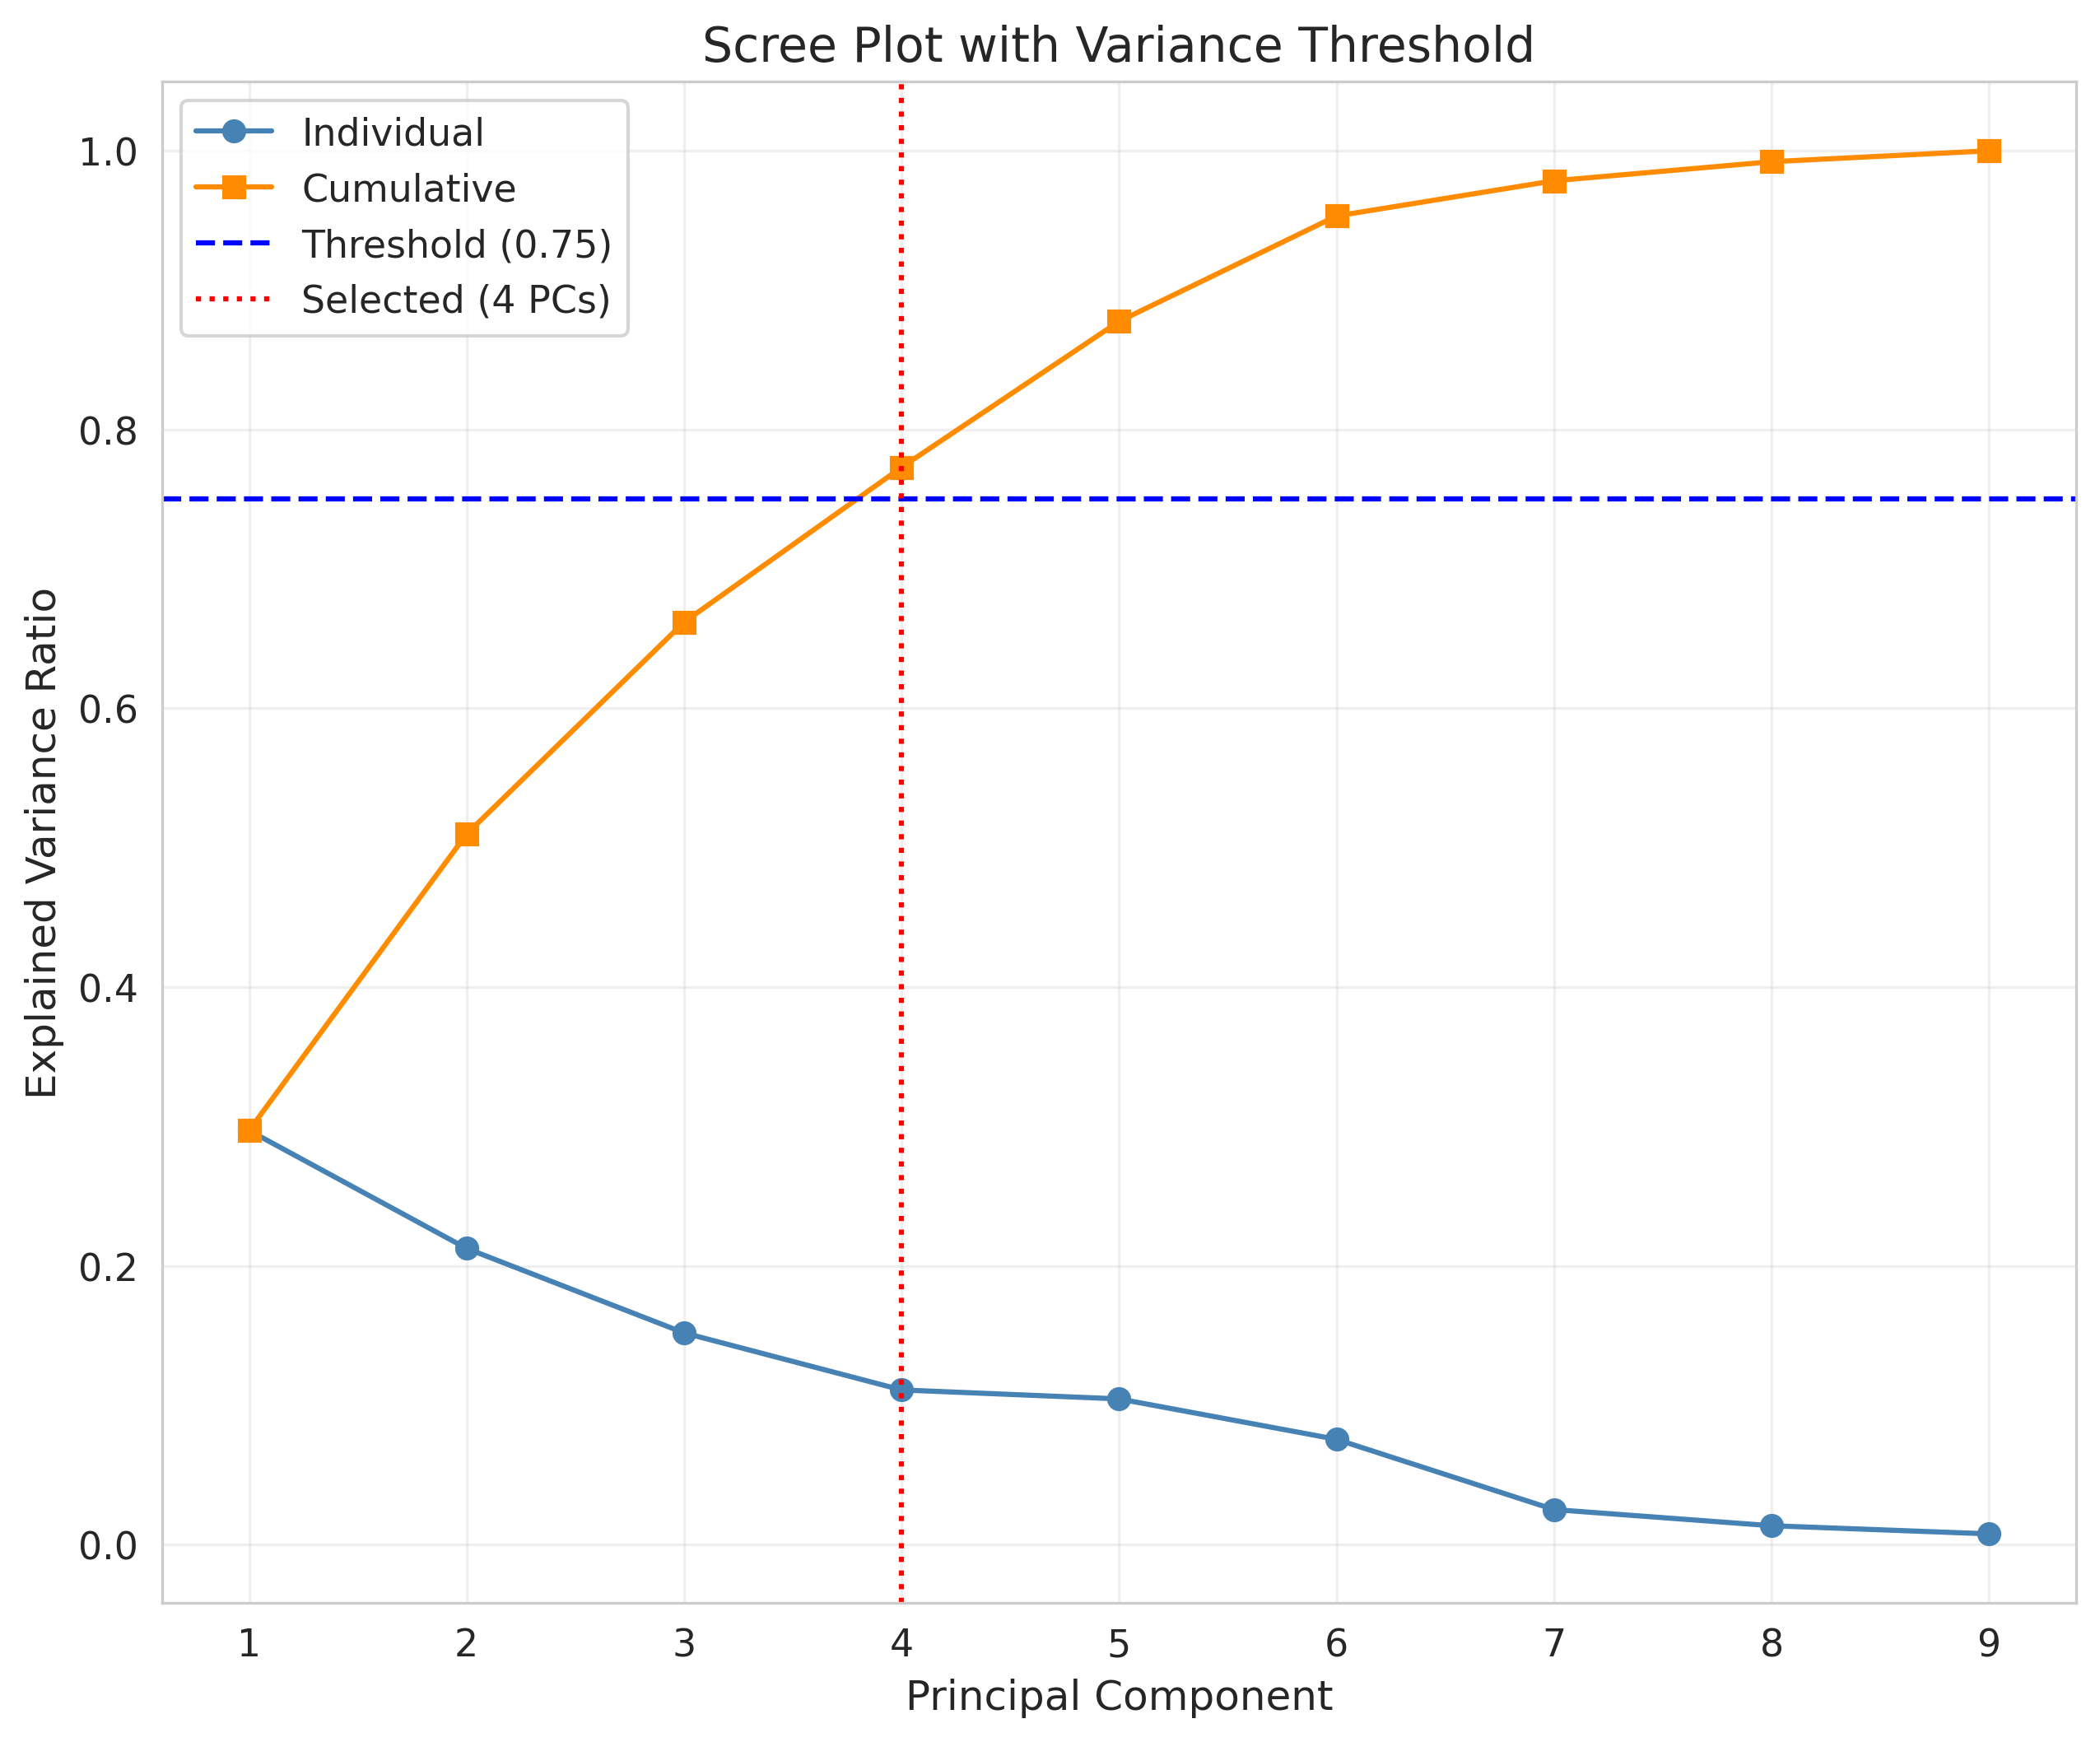

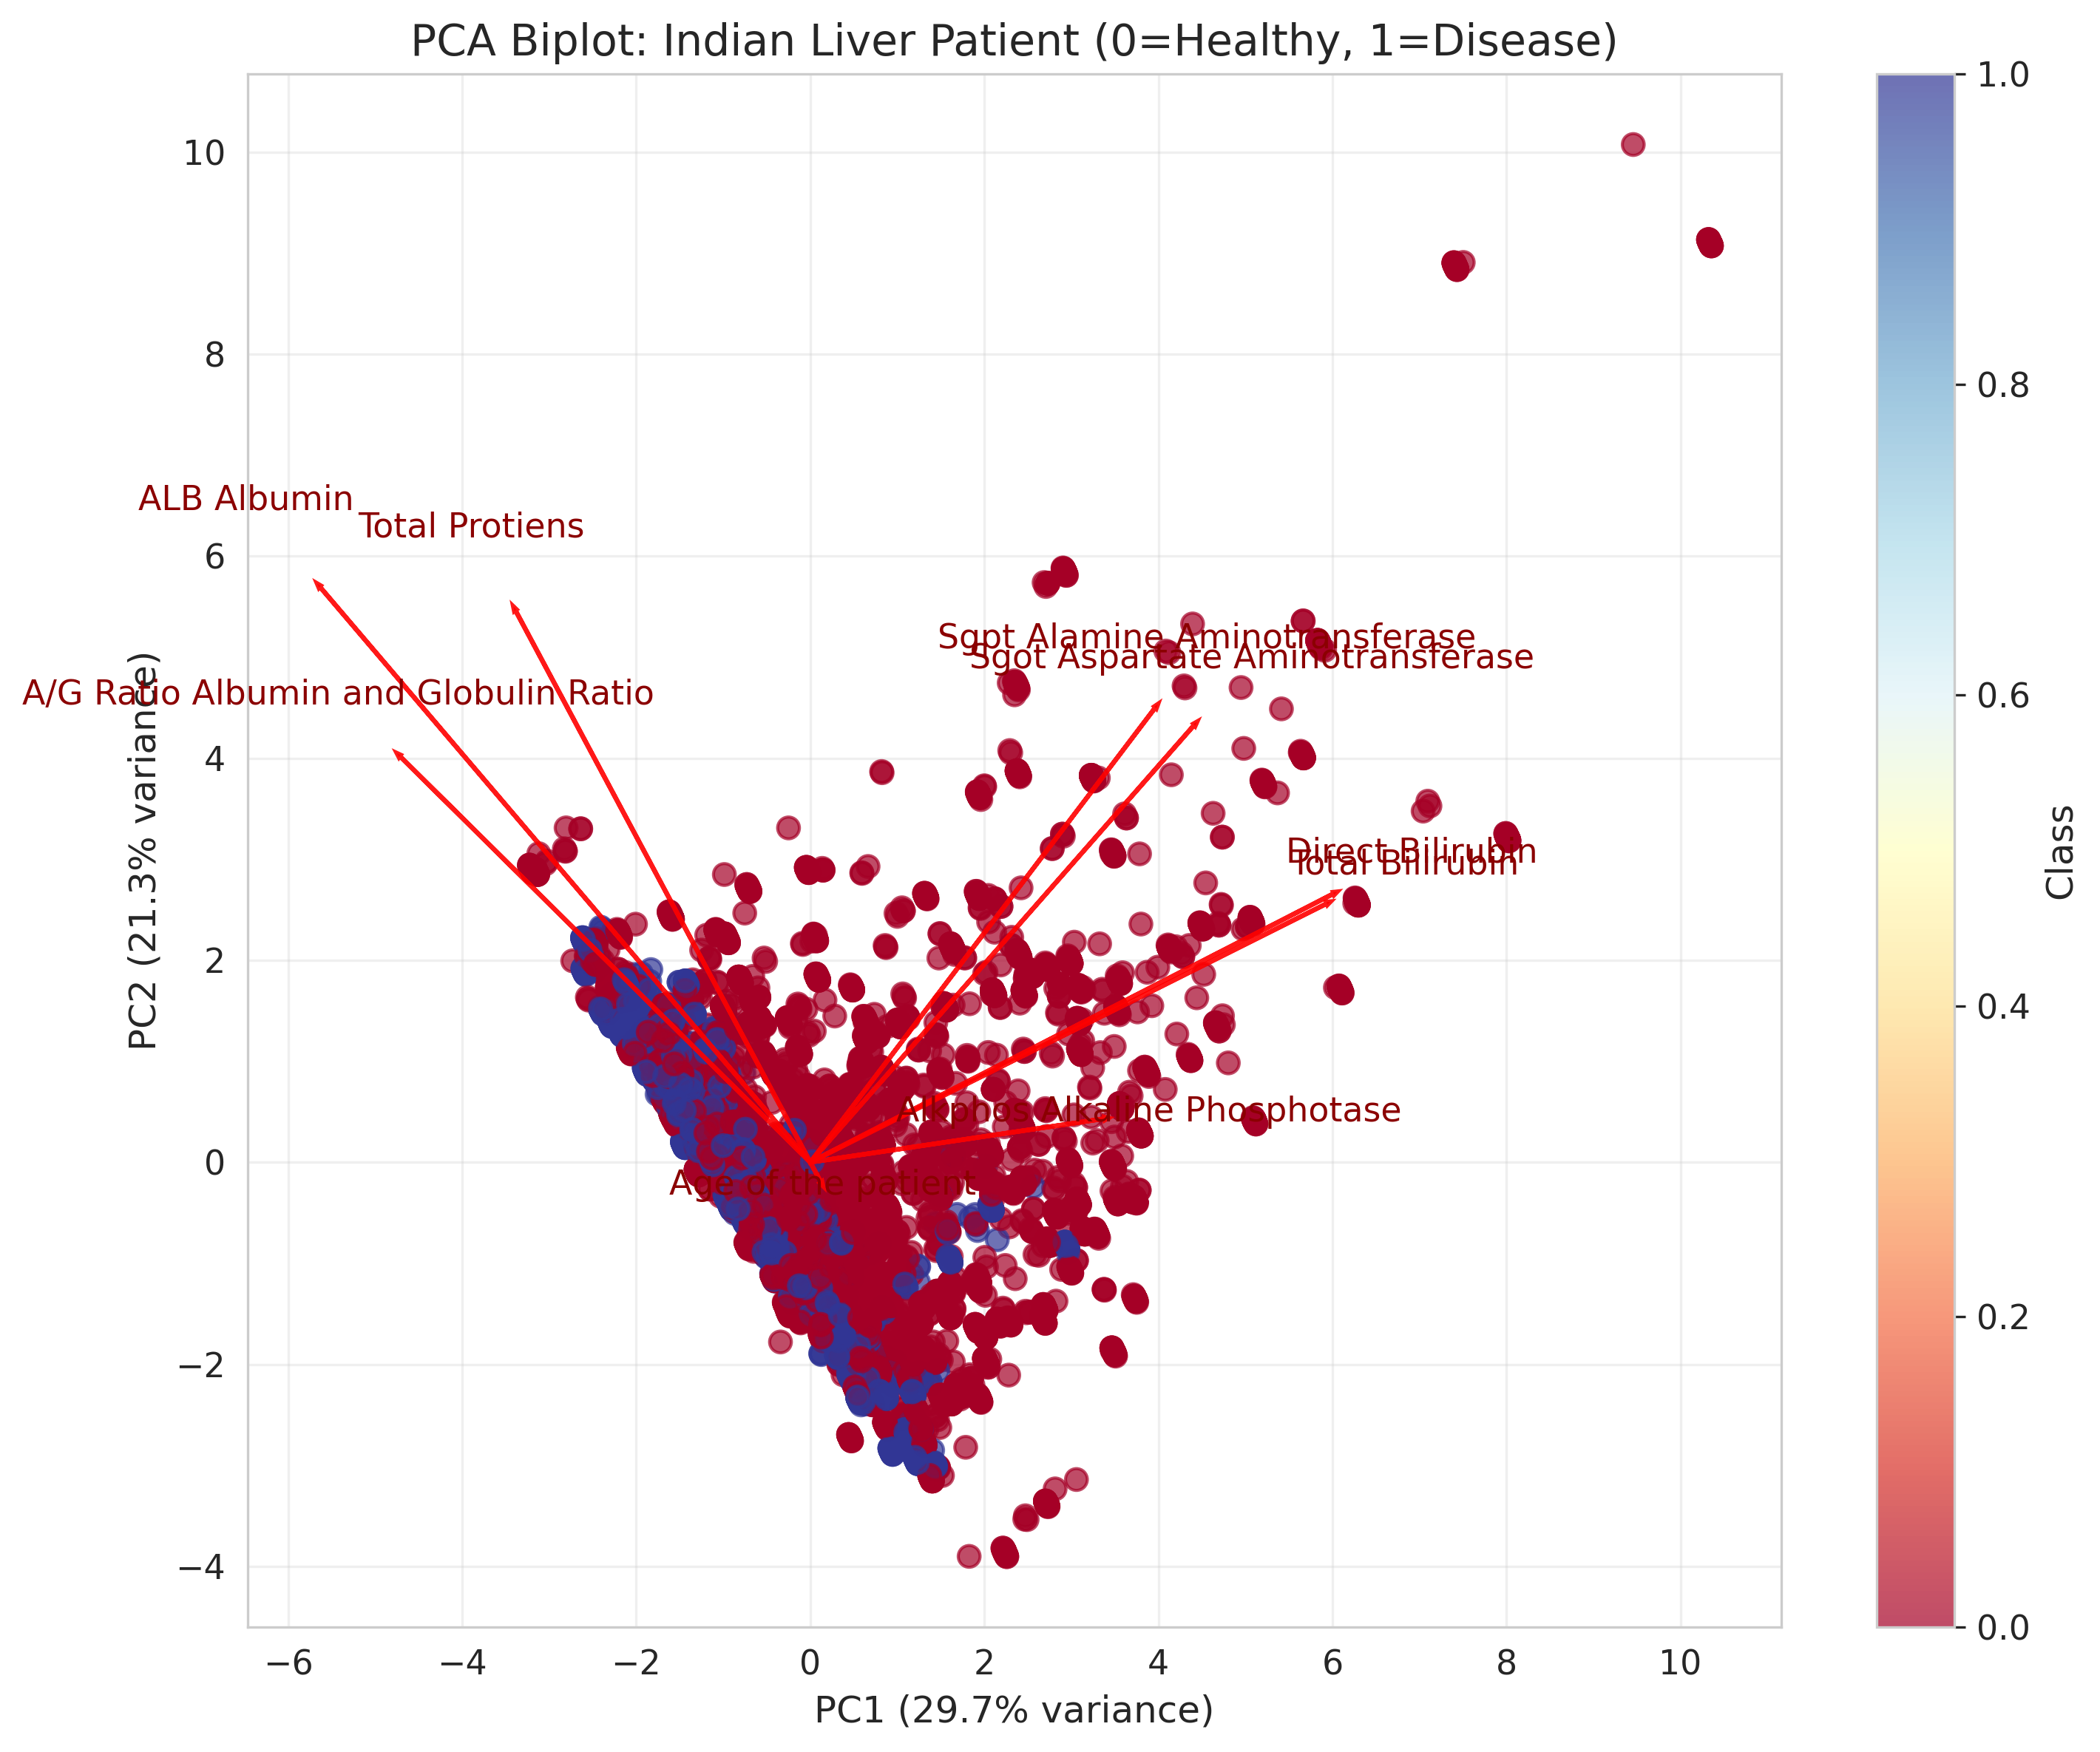


LOADINGS (PC Contribution):
                                         PC1     PC2     PC3     PC4
Age of the patient                    0.0147 -0.0238  0.0250  0.9986
Total Bilirubin                       0.7167  0.3093 -0.5264  0.0011
Direct Bilirubin                      0.7260  0.3210 -0.5136  0.0012
Alkphos Alkaline Phosphotase          0.4083  0.0522 -0.0921  0.0089
Sgpt Alamine Aminotransferase         0.4786  0.5433  0.6015 -0.0093
Sgot Aspartate Aminotransferase       0.5327  0.5225  0.5656 -0.0002
Total Protiens                       -0.4091  0.6595 -0.3433  0.0412
ALB Albumin                          -0.6804  0.6877 -0.1266  0.0164
A/G Ratio Albumin and Globulin Ratio -0.5694  0.4853  0.0499 -0.0221

CORRELATION WITH PC1:
Direct Bilirubin                        0.7260
Total Bilirubin                         0.7167
Sgot Aspartate Aminotransferase         0.5327
Sgpt Alamine Aminotransferase           0.4786
Alkphos Alkaline Phosphotase            0.4083
Age of the patient     

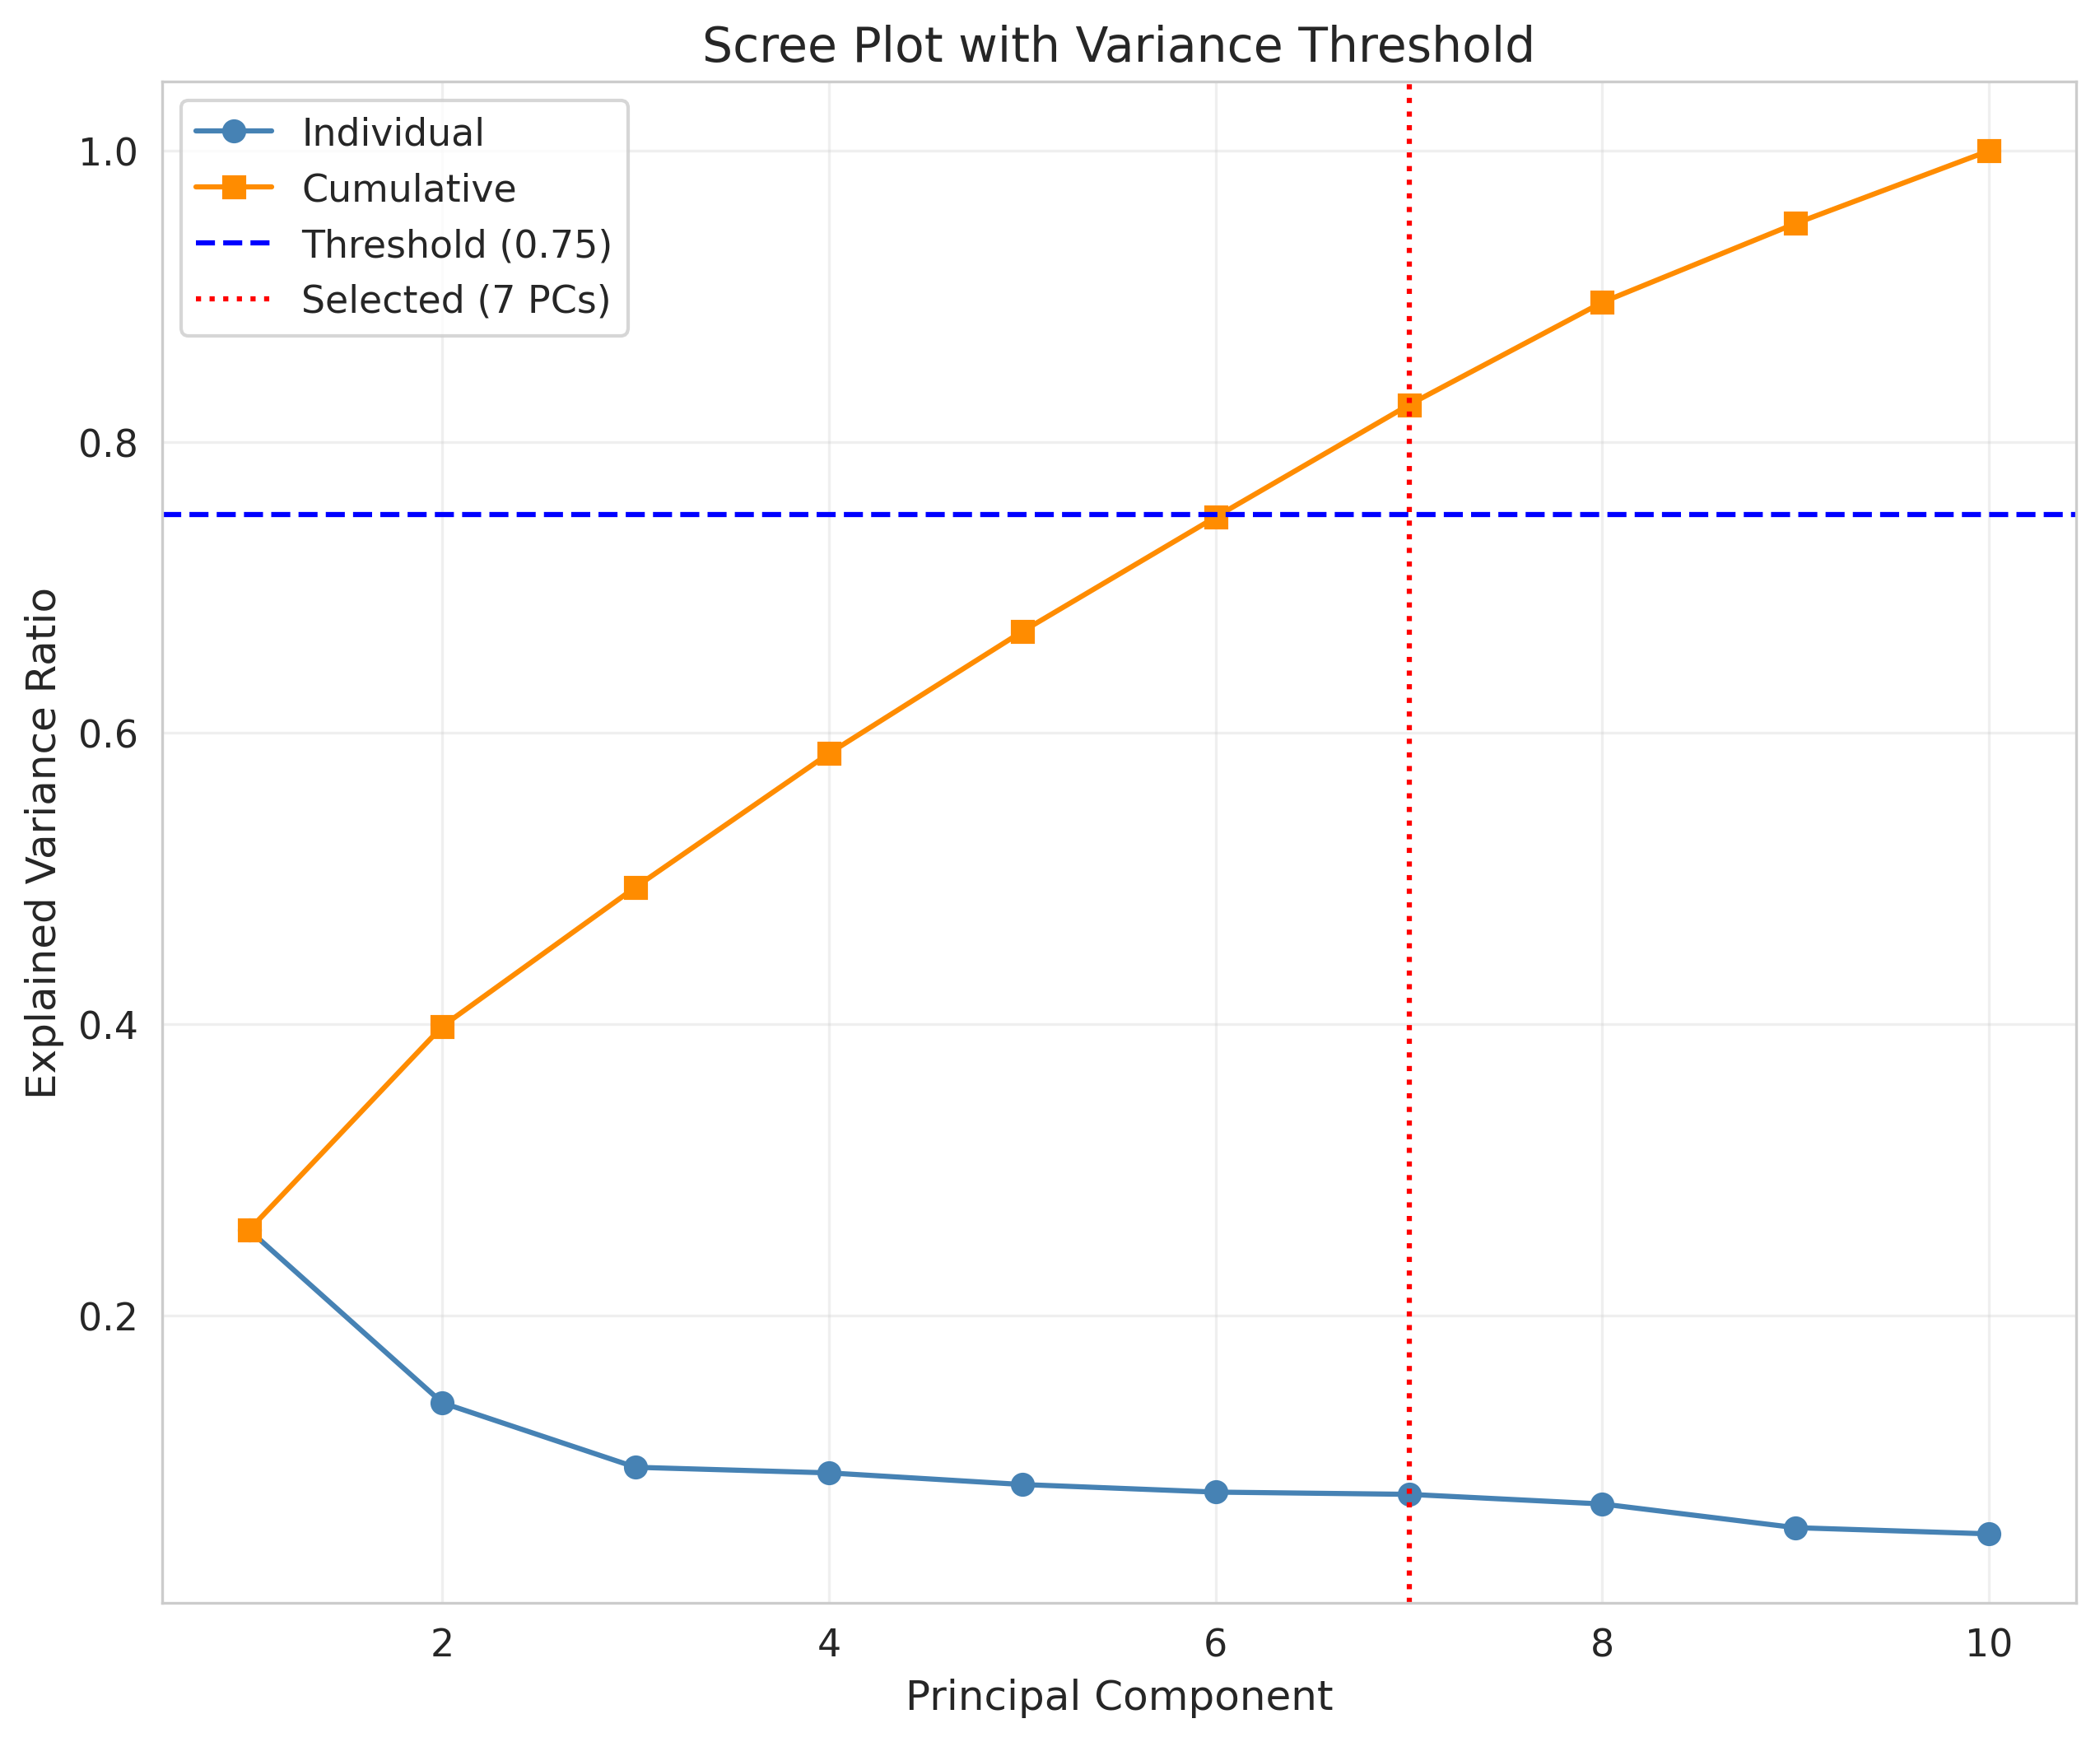

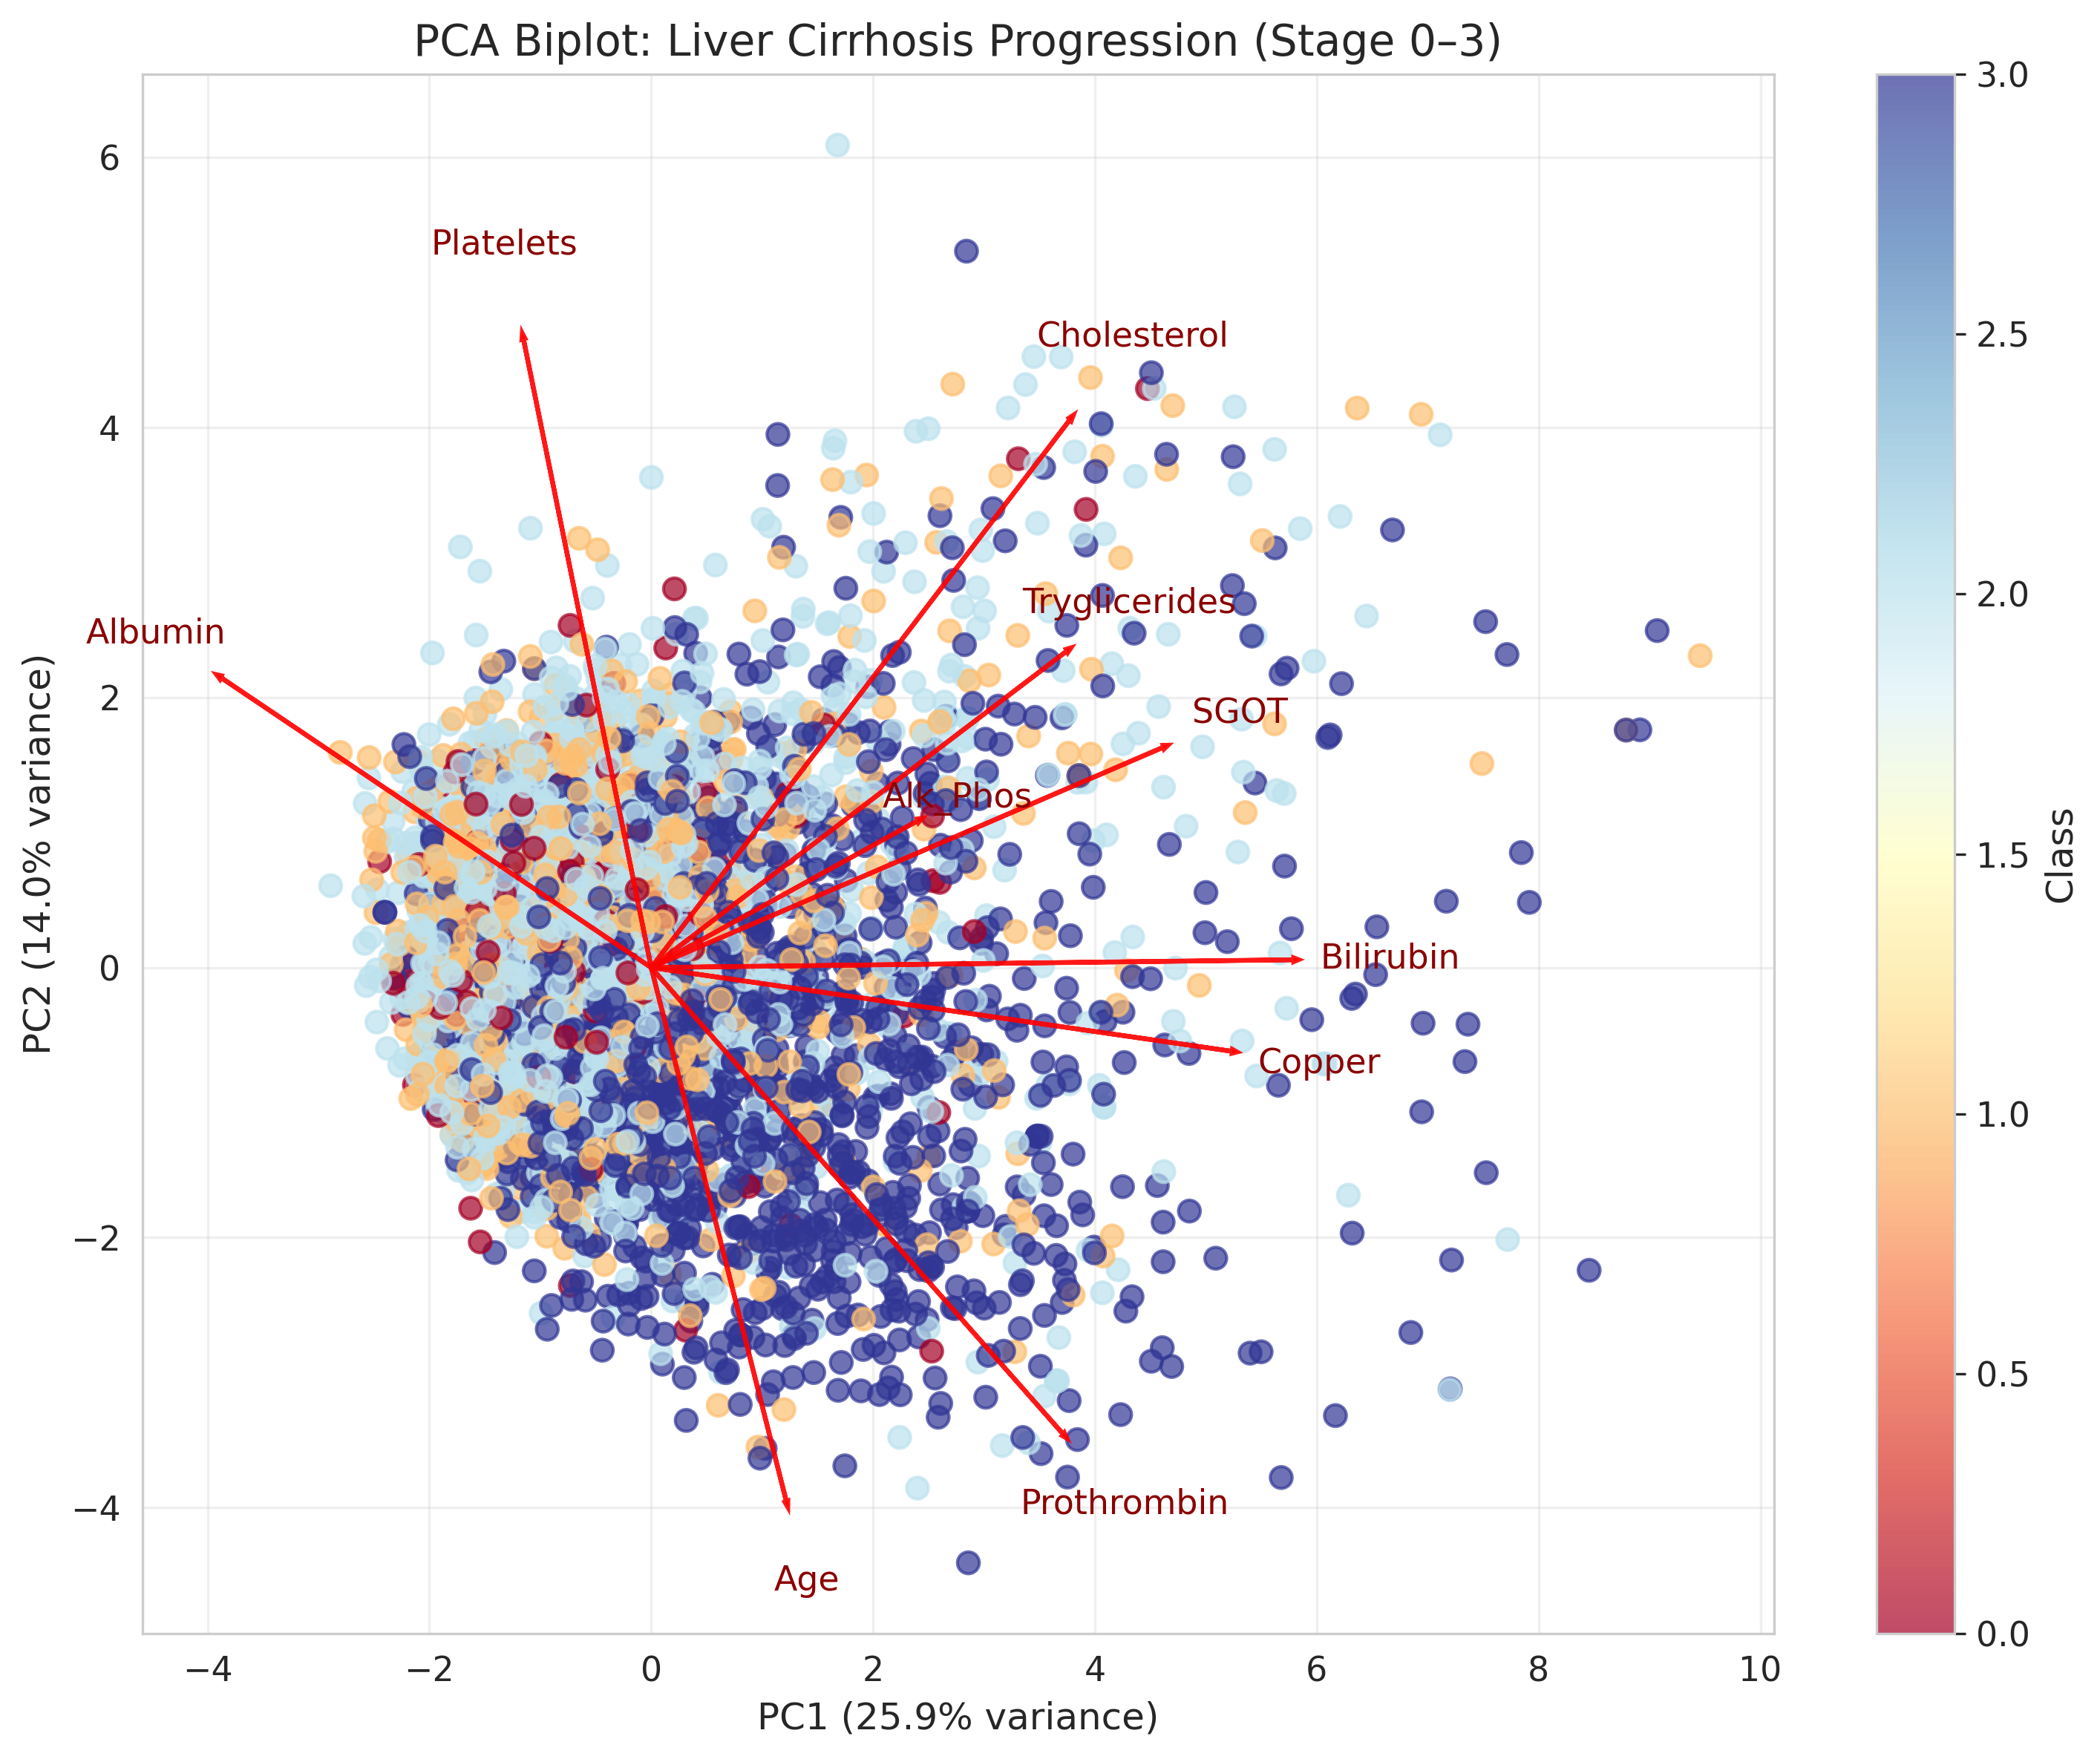


LOADINGS (PC Contribution):
                  PC1     PC2     PC3     PC4     PC5     PC6     PC7
Age            0.1611 -0.5227  0.3924  0.4870  0.4896 -0.2604  0.0297
Bilirubin      0.7656  0.0076 -0.0976  0.1150 -0.0488  0.1053  0.0826
Cholesterol    0.4991  0.5366 -0.1371  0.0638  0.2171 -0.2728  0.0453
Albumin       -0.5129  0.2841  0.0072  0.2390 -0.1351 -0.1626  0.7367
Copper         0.6923 -0.0820 -0.0599  0.0537 -0.1068  0.1382  0.1317
Alk_Phos       0.3177  0.1438  0.7649 -0.4503 -0.1957 -0.2138  0.0688
SGOT           0.6104  0.2158 -0.2304 -0.3047  0.3960 -0.1334  0.1596
Tryglicerides  0.4954  0.3100  0.0895  0.5263 -0.4508 -0.1078 -0.2088
Platelets     -0.1522  0.6155  0.3471  0.1725  0.3322  0.5756 -0.0418
Prothrombin    0.4910 -0.4569  0.0638 -0.0375 -0.1038  0.4253  0.3540

CORRELATION WITH PC1:
Bilirubin        0.7656
Copper           0.6923
SGOT             0.6104
Cholesterol      0.4991
Tryglicerides    0.4953
Prothrombin      0.4909
Alk_Phos         0.3176
Age       

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

warnings.filterwarnings("ignore")
plt.rcParams.update({
    'figure.figsize': (10, 8),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'font.family': 'DejaVu Sans',  # Use available font to avoid Arial warning
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif']
})

# Suppress font warnings globally
fm._get_fontconfig_fonts = lambda: []  # Disable font cache scanning
os.environ['MPLCONFIGDIR'] = '/tmp'   # Avoid font cache issues in Colab

# ----------------------------------------------------------------
# 2. CREATE OUTPUT DIRECTORY
# ----------------------------------------------------------------
output_dir = "Results"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# ----------------------------------------------------------------
# 3. LOAD & CLEAN DATA
# ----------------------------------------------------------------
try:
    indian = pd.read_csv("/content/Data/liver_cleaned.csv")
    cirrhosis = pd.read_csv("/content/Data/cirrhosis_encoded.csv")
    print("Data loaded successfully.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"File not found: {e}")

# --- INDIAN DATASET ---
indian['Result'] = indian['Result'].map({1: 0, 2: 1})
print(f"Indian: {indian.shape[0]} samples, {indian.shape[1]} features")

# --- CIRRHOSIS DATASET ---
cirrhosis = cirrhosis.drop(columns=['id', 'N_Days'], errors='ignore')
cirrhosis['Stage'] = cirrhosis['Stage'] - 1  # 1,2,3,4 → 0,1,2,3
print(f"Cirrhosis (after drop ID/N_Days): {cirrhosis.shape[0]} samples, {cirrhosis.shape[1]} features")

print(f"Indian class: {indian['Result'].value_counts(normalize=True).round(3).to_dict()}")
print(f"Cirrhosis stage: {cirrhosis['Stage'].value_counts(normalize=True).round(3).to_dict()}")


choosen_scaler = 'standard'  # or 'robust'
variance_threshold = 0.75

print(f"\nPCA Configuration:")
print(f"   • Variance threshold: {variance_threshold}")
print(f"   • Scaler: {choosen_scaler.capitalize()}Scaler")

# ----------------------------------------------------------------
# 5. INDIAN LIVER PATIENT DATASET
# ----------------------------------------------------------------
print("\n" + "="*70)
print("1. INDIAN LIVER PATIENT DATASET")
print("="*70)

pca_indian = AcademicPCA(
    min_explained_variance=variance_threshold,
    scaler=choosen_scaler,
    random_state=42
)

pca_indian.fit(indian.drop('Result', axis=1), y=indian['Result'])

pca_indian.scree_plot(save_path=f"{output_dir}/indian_scree_plot_{choosen_scaler}.png")
pca_indian.biplot(
    y=indian['Result'],
    title="PCA Biplot: Indian Liver Patient (0=Healthy, 1=Disease)",
    save_path=f"{output_dir}/indian_biplot_{choosen_scaler}.png"
)

print("\nLOADINGS (PC Contribution):")
loadings_indian = pca_indian.get_loadings()
print(loadings_indian)

print("\nCORRELATION WITH PC1:")
corr_pc1_indian = pca_indian.correlation_with_pc1(indian.drop('Result', axis=1))
print(corr_pc1_indian)

pca_indian.summary()

# ----------------------------------------------------------------
# 6. LIVER CIRRHOSIS DATASET
# ----------------------------------------------------------------
print("\n" + "="*70)
print("2. LIVER CIRRHOSIS DATASET (Stage 0–3)")
print("="*70)

pca_cirrhosis = AcademicPCA(
    min_explained_variance=variance_threshold,
    scaler=choosen_scaler,
    random_state=42
)

pca_cirrhosis.fit(cirrhosis.drop('Stage', axis=1), y=cirrhosis['Stage'])

pca_cirrhosis.scree_plot(save_path=f"{output_dir}/cirrhosis_scree_plot_{choosen_scaler}.png")
pca_cirrhosis.biplot(
    y=cirrhosis['Stage'],
    title="PCA Biplot: Liver Cirrhosis Progression (Stage 0–3)",
    save_path=f"{output_dir}/cirrhosis_biplot_{choosen_scaler}.png"
)

print("\nLOADINGS (PC Contribution):")
loadings_cirrhosis = pca_cirrhosis.get_loadings()
print(loadings_cirrhosis)

print("\nCORRELATION WITH PC1:")
corr_pc1_cirrhosis = pca_cirrhosis.correlation_with_pc1(cirrhosis.drop('Stage', axis=1))
print(corr_pc1_cirrhosis)

pca_cirrhosis.summary()

loadings_indian.to_csv(f"{output_dir}/indian_loadings_{choosen_scaler}.csv")
loadings_cirrhosis.to_csv(f"{output_dir}/cirrhosis_loadings_{choosen_scaler}.csv")
corr_pc1_indian.to_csv(f"{output_dir}/indian_pc1_corr_{choosen_scaler}.csv")
corr_pc1_cirrhosis.to_csv(f"{output_dir}/cirrhosis_pc1_corr_{choosen_scaler}.csv")

print(f"\nAll results saved to: {output_dir}/")

print("\n" + "="*70)
print("CLINICAL INSIGHTS FROM PCA")
print("="*70)

print("INDIAN LIVER:")
for feat, val in corr_pc1_indian.head(5).items():
    print(f"   • {feat}: {'↑' if val > 0 else '↓'} (r = {val:.3f})")

print("\nCIRRHOSIS:")
for feat, val in corr_pc1_cirrhosis.head(5).items():
    print(f"   • {feat}: {'↑' if val > 0 else '↓'} (r = {val:.3f})")

print("\nSame direction → strong correlation | Opposite → compensation")
print("="*70)